# SSD512 Transfer learning


In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss



%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 512
img_width = 512

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               clip_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=[2, 1, 0],
               confidence_thresh=0.5,
               iou_threshold=0.45,
               top_k=200,
               nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights. 
weights_path = 'VGG_VOC0712_SSD_512x512_iter_120000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.cast` instead.


## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [4]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'examples/fish_bike.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img)
input_images.append(img)
input_images = np.array(input_images)

## 3. Make predictions

In [5]:
y_pred = model.predict(input_images)

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [6]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 15.     1.    31.74 230.49 279.25 508.73]
 [ 15.     1.     2.49 186.91 107.86 437.62]
 [ 20.     0.87  97.73 240.   165.1  334.76]
 [ 15.     0.86 262.79 115.8  305.41 279.57]
 [ 15.     0.72 318.98 239.01 403.98 368.13]
 [ 20.     0.6  268.07 227.16 319.51 303.26]]


In [7]:
persons = []
for box in y_pred_thresh[0]:
    if box[0] == 15:
        persons.append(box)
        
print(persons)

[array([ 15.  ,   1.  ,  31.74, 230.49, 279.25, 508.73], dtype=float32), array([ 15.  ,   1.  ,   2.49, 186.91, 107.86, 437.62], dtype=float32), array([ 15.  ,   0.86, 262.79, 115.8 , 305.41, 279.57], dtype=float32), array([ 15.  ,   0.72, 318.98, 239.01, 403.98, 368.13], dtype=float32)]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

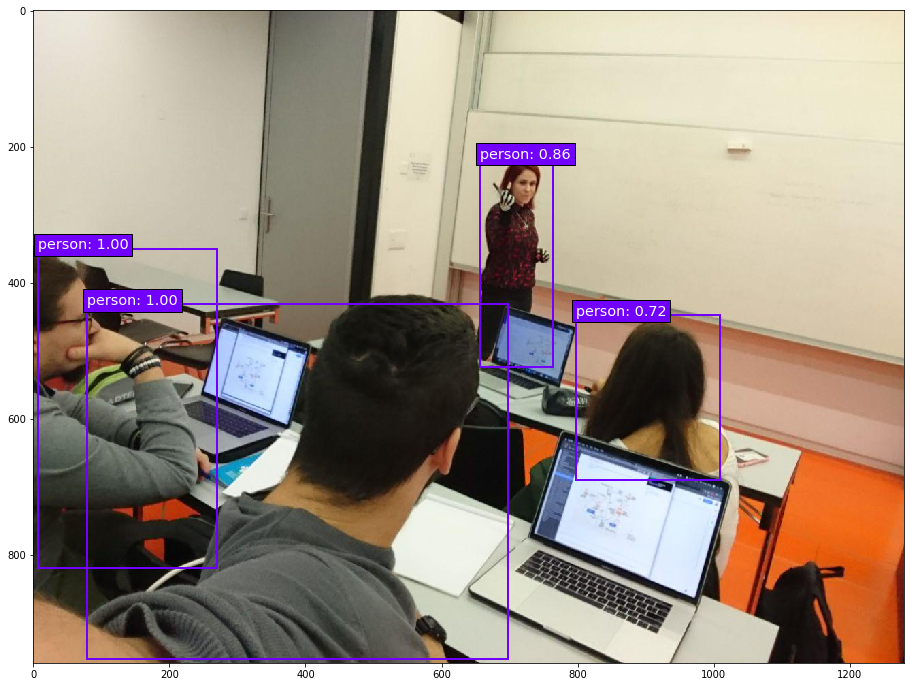

In [8]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in persons:
    # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
    xmin = box[-4] * orig_images[0].shape[1] / img_width
    ymin = box[-3] * orig_images[0].shape[0] / img_height
    xmax = box[-2] * orig_images[0].shape[1] / img_width
    ymax = box[-1] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [9]:
print(len(model.layers))

88


In [10]:
print([1,model.layers[7].get_input_shape_at(0)[1]])

[1, 256]


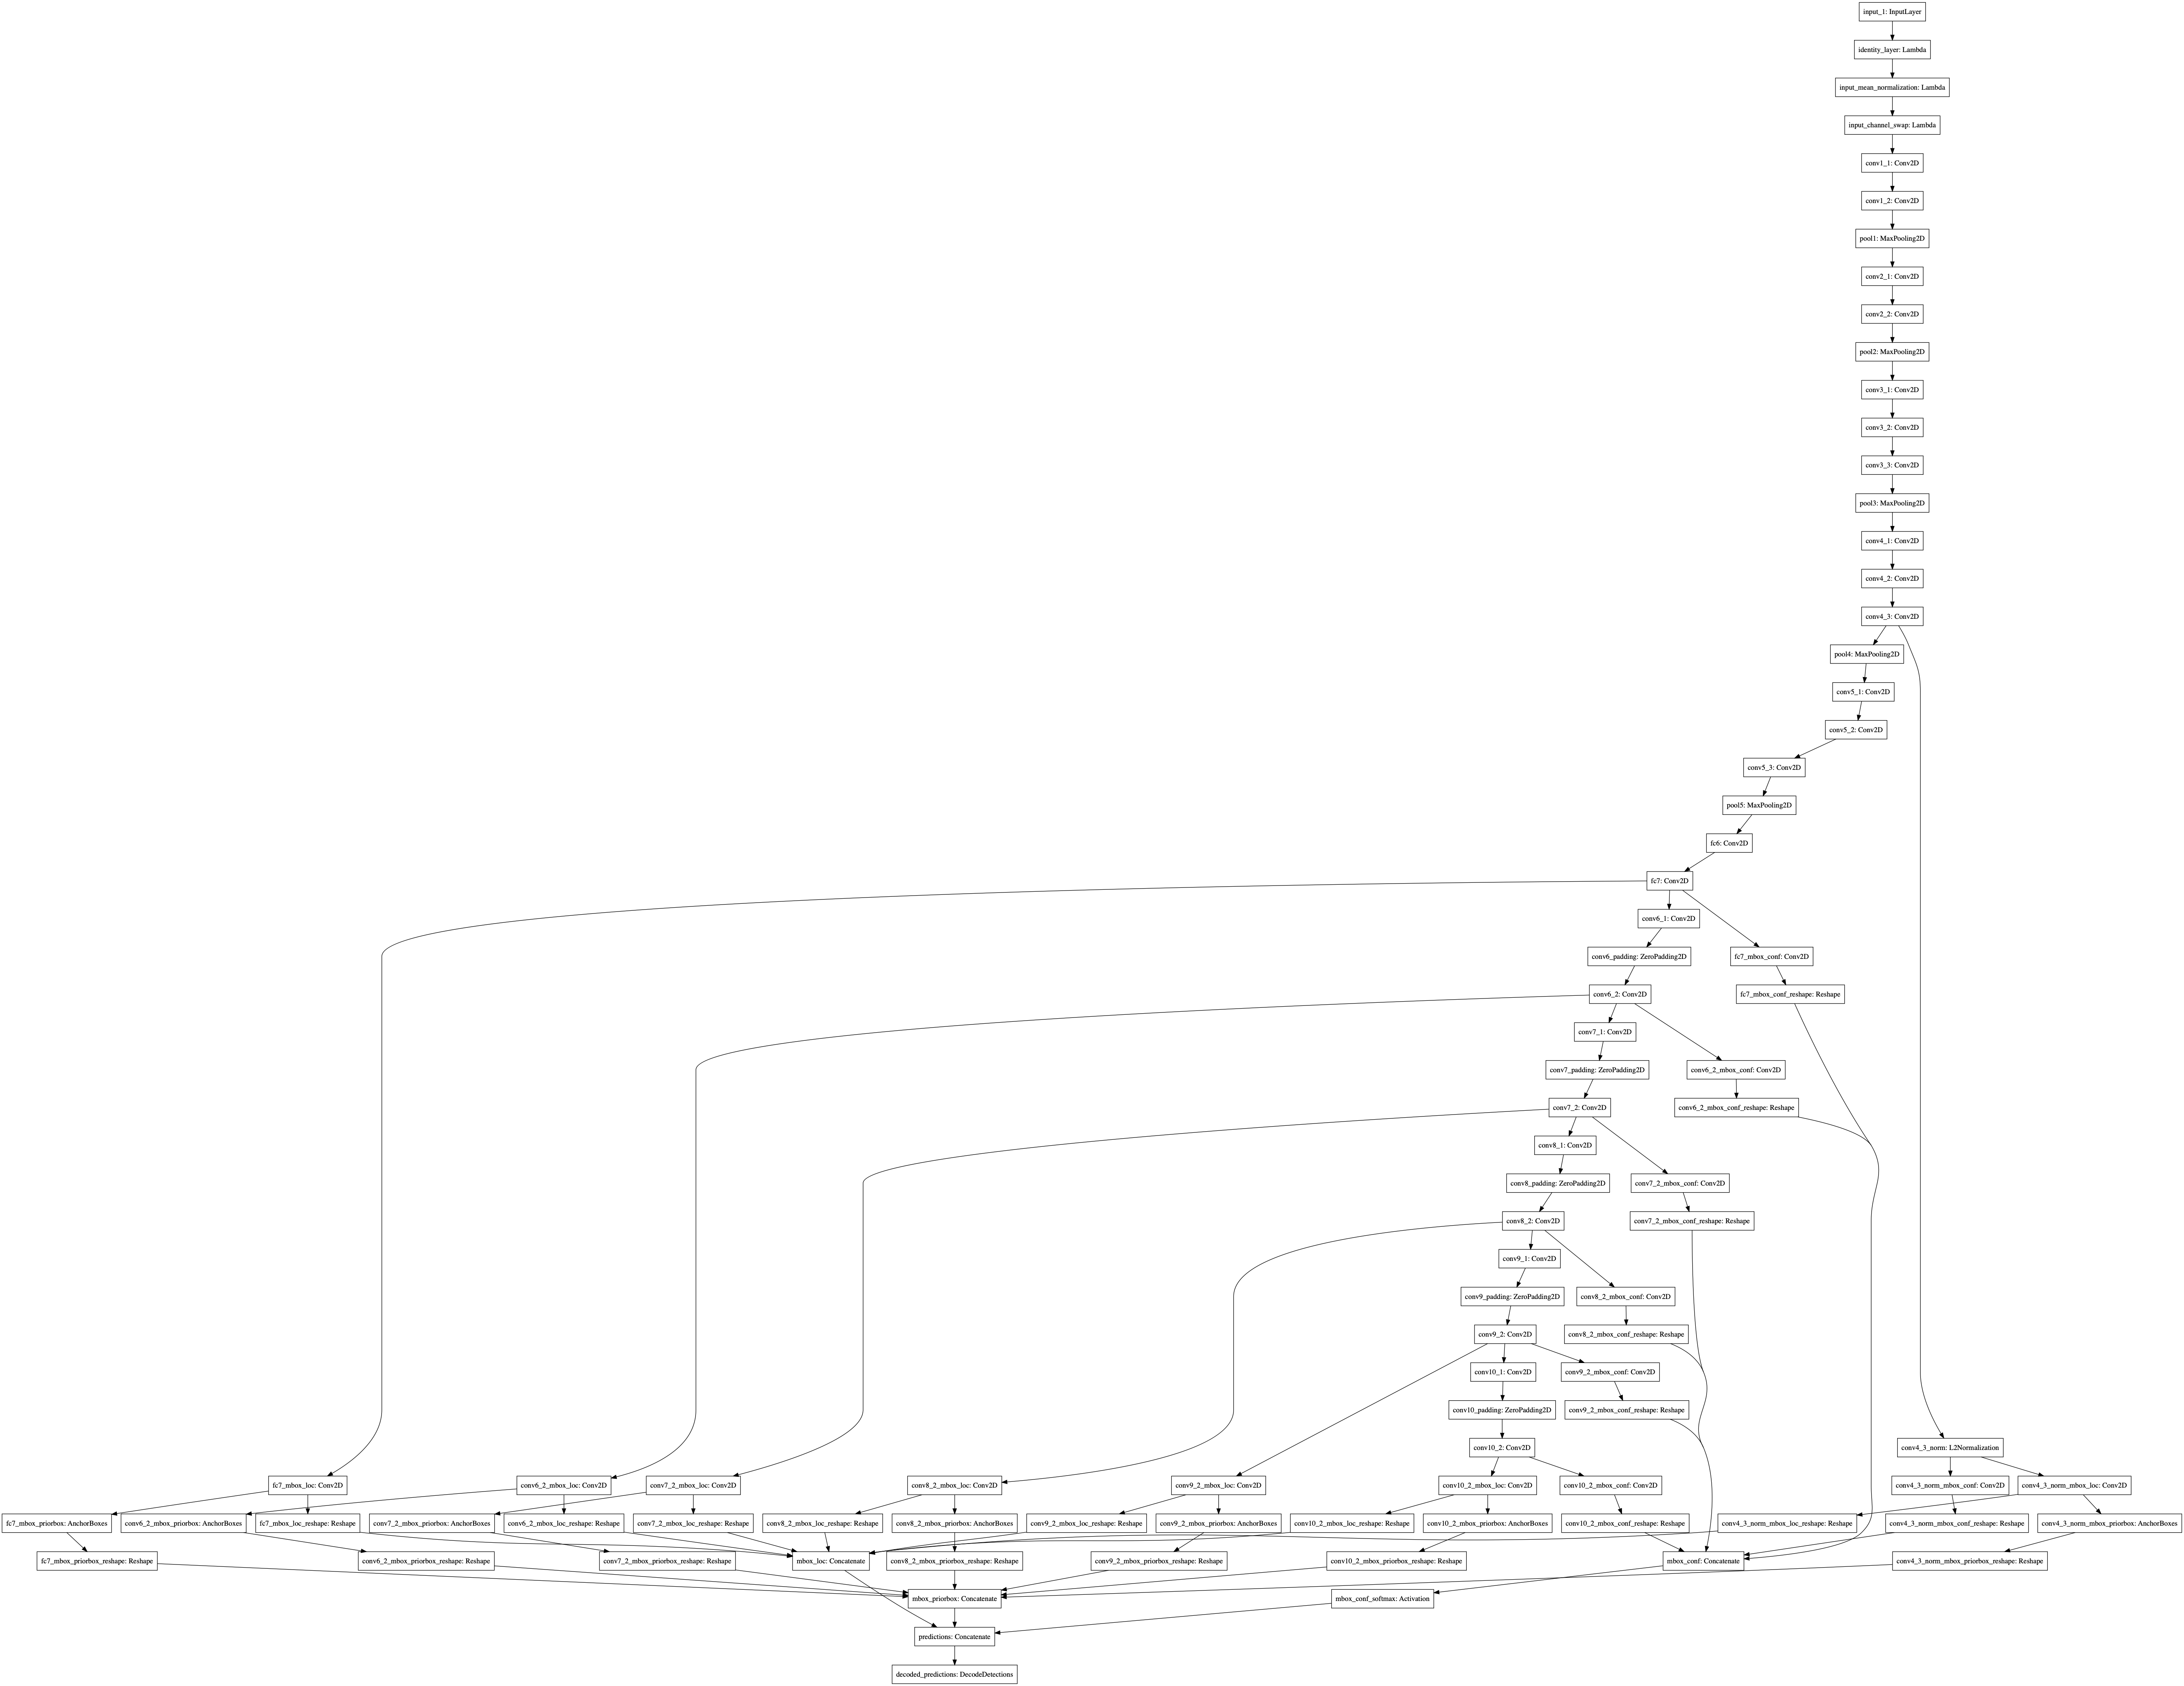

In [11]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')

In [12]:
def get_output_of_layer(layer):
    # if we have already applied this layer on its input(s) tensors,
    # just return its already computed output
    if layer.name in layer_outputs:
        return layer_outputs[layer.name]

    # if this is the starting layer, then apply it on the input tensor
    if layer.name == starting_layer_name:
        out = layer(new_input)
        layer_outputs[layer.name] = out
        return out

    # find all the connected layers which this layer
    # consumes their output
    prev_layers = []
    for node in layer._inbound_nodes:
        prev_layers.extend(node.inbound_layers)

    # get the output of connected layers
    pl_outs = []
    for pl in prev_layers:
        pl_outs.extend([get_output_of_layer(pl)])

    # apply this layer on the collected outputs
    print(layer.name)
    out = layer(pl_outs[0] if len(pl_outs) == 1 else pl_outs)
    layer_outputs[layer.name] = out
    return out


In [13]:
from keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Reshape, Concatenate
from keras.models import Model
from keras import layers

In [14]:


layer_outputs = {}
starting_layer_name = "conv2_1"
new_input = layers.Input(batch_shape=model.get_layer(starting_layer_name).get_input_shape_at(0))
new_output = get_output_of_layer(model.layers[-1])

# create the sub-model
model2 = Model(new_input, new_output)


model2.summary()

conv2_2
pool2
conv3_1
conv3_2
conv3_3
pool3
conv4_1
conv4_2
conv4_3
conv4_3_norm
conv4_3_norm_mbox_conf
conv4_3_norm_mbox_conf_reshape
pool4
conv5_1
conv5_2
conv5_3
pool5
fc6
fc7
fc7_mbox_conf
fc7_mbox_conf_reshape
conv6_1
conv6_padding
conv6_2
conv6_2_mbox_conf
conv6_2_mbox_conf_reshape
conv7_1
conv7_padding
conv7_2
conv7_2_mbox_conf
conv7_2_mbox_conf_reshape
conv8_1
conv8_padding
conv8_2
conv8_2_mbox_conf
conv8_2_mbox_conf_reshape
conv9_1
conv9_padding
conv9_2
conv9_2_mbox_conf
conv9_2_mbox_conf_reshape
conv10_1
conv10_padding
conv10_2
conv10_2_mbox_conf
conv10_2_mbox_conf_reshape
mbox_conf
mbox_conf_softmax
conv4_3_norm_mbox_loc
conv4_3_norm_mbox_loc_reshape
fc7_mbox_loc
fc7_mbox_loc_reshape
conv6_2_mbox_loc
conv6_2_mbox_loc_reshape
conv7_2_mbox_loc
conv7_2_mbox_loc_reshape
conv8_2_mbox_loc
conv8_2_mbox_loc_reshape
conv9_2_mbox_loc
conv9_2_mbox_loc_reshape
conv10_2_mbox_loc
conv10_2_mbox_loc_reshape
mbox_loc
conv4_3_norm_mbox_priorbox
conv4_3_norm_mbox_priorbox_reshape
fc7_mbox_prio

In [15]:
model2.save('secondpart.h5')

In [16]:
def get_output_of_layer(layer):
    # if we have already applied this layer on its input(s) tensors,
    # just return its already computed output
    if layer.name in layer_outputs:
        return layer_outputs[layer.name]

    # if this is the starting layer, then apply it on the input tensor
    if layer.name == starting_layer_name:
        out = layer(new_input)
        layer_outputs[layer.name] = out
        return out

    # find all the connected layers which this layer
    # consumes their output
    prev_layers = []
    for node in layer._inbound_nodes:
        prev_layers.extend(node.inbound_layers)

    # get the output of connected layers
    pl_outs = []
    for pl in prev_layers:
        pl_outs.extend([get_output_of_layer(pl)])

    # apply this layer on the collected outputs
    print(layer.name)
    out = layer(pl_outs[0] if len(pl_outs) == 1 else pl_outs)
    layer_outputs[layer.name] = out
    return out


In [17]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

idx = getLayerIndexByName(model, 'pool1')

In [18]:
layer_outputs = {}
starting_layer_name = "input_mean_normalization"
new_input = layers.Input(batch_shape=model.get_layer("input_1").get_input_shape_at(0))
new_output = get_output_of_layer(model.layers[idx])

input_channel_swap
conv1_1
conv1_2
pool1


In [19]:
model1 = Model(inputs=new_input, outputs=new_output)


model1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
input_mean_normalization (La (None, 512, 512, 3)       0         
_________________________________________________________________
input_channel_swap (Lambda)  (None, 512, 512, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 512, 512, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 512, 512, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 256, 256, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_______________________________________________________

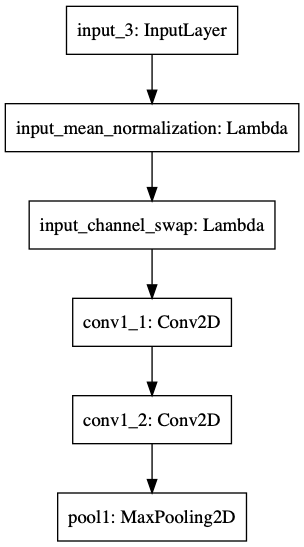

In [20]:
plot_model(model1, to_file='model1.png')

In [21]:
model1.save('firstpart.h5')

In [22]:
y_pred = model1.predict(input_images)

In [23]:
y_pred = model2.predict(y_pred)

In [24]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

persons = []
for box in y_pred_thresh[0]:
    if box[0] == 15:
        persons.append(box)
        
print(persons)

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 15.     1.    31.74 230.49 279.25 508.73]
 [ 15.     1.     2.49 186.91 107.86 437.62]
 [ 20.     0.87  97.73 240.   165.1  334.76]
 [ 15.     0.86 262.79 115.8  305.41 279.57]
 [ 15.     0.72 318.98 239.01 403.98 368.13]
 [ 20.     0.6  268.07 227.16 319.51 303.26]]
[array([ 15.  ,   1.  ,  31.74, 230.49, 279.25, 508.73], dtype=float32), array([ 15.  ,   1.  ,   2.49, 186.91, 107.86, 437.62], dtype=float32), array([ 15.  ,   0.86, 262.79, 115.8 , 305.41, 279.57], dtype=float32), array([ 15.  ,   0.72, 318.98, 239.01, 403.98, 368.13], dtype=float32)]


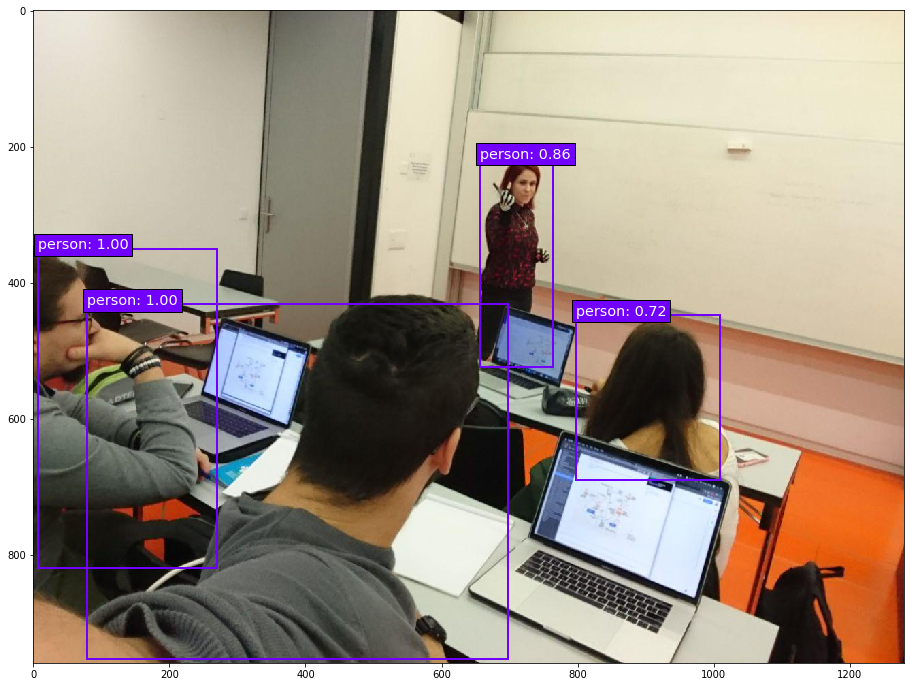

In [25]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in persons:
    # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
    xmin = box[-4] * orig_images[0].shape[1] / img_width
    ymin = box[-3] * orig_images[0].shape[0] / img_height
    xmax = box[-2] * orig_images[0].shape[1] / img_width
    ymax = box[-1] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [26]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model_file("firstpart.h5")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()
open("converted_model.tflite", "wb").write(quantized_model)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.


42304